# Finding datasets that have stopped being updated
This notebook shows how to find datasets that have stopped being updated.
It looks across all datasets and finds the datasets that have been stopped and then 
does analysis with the table types to show which have the highest percentage of being stopped.
This can be extended to find for departments that have stopped releasing certain types of data, what other types are they still releasing.

In [9]:
import openpolicedata as opd
import pandas as pd
import matplotlib.pyplot as plt
opd.__version__

'0.9'

In [10]:
# These are the parameters for the analysis that can be adjusted

# Flag to remove California data to make sure it is not driving the findings
remove_california_stops_data = True

# Flag to create a debug file with removed datasets
create_debug_file = False

# The below parameters are used to configure the final graphs

# These are the minimum and maximum years for what the final graphs will show
analysis_year_min = 1960
analysis_year_max = 2024

# This is the minimum number of counts needed to show a table type in the final graphs
minimum_tabletype_counts_to_show = 10

In [11]:
# Helper functions go in this cell
def remove_rows(remove_condition, all_datasets, debug_filename=None):
    
    starting_all_datasets_count = all_datasets.shape[0]
    
    remove_datasets = all_datasets[remove_condition]
        
    # # Drop the identified rows
    all_datasets.drop(remove_datasets.index, inplace=True)
        
    # Verify the number of datasets removed
    assert len(remove_datasets) == (starting_all_datasets_count - all_datasets.shape[0]), \
        "Mismatch in the number of datasets removed"
        
    # Save removed datasets if a debug filename is provided
    if debug_filename:
        remove_datasets.to_csv(debug_filename, index=True)
    
    return all_datasets

# Used to create debug files if the create_debug_file flag is set to True
get_fn = lambda fn: fn if create_debug_file else None

In [12]:
# This cell filters out datasets that are not of interest to the analysis

# For the analysis we will exclude the openpolicing.stanford.edu and muckrock to prevent duplicates
all_datasets_original = opd.datasets.query()
# all_datasets is the filtered dataset with only the rows we are interested in
all_datasets = all_datasets_original.copy()

# Remove datasets where the data is not supplied by the agency itself
# supplying_entity is only filled out in this case. Ignore one where OPD is hosting the data
# OPD only hosts datasets that were released by the agency but the agency stopped.
# Remove datasets where the data is not supplied by the agency itself
all_datasets=remove_rows(all_datasets['supplying_entity'].apply(lambda x: not (pd.isnull(x) or 'OpenPoliceData' in x)),
                                     all_datasets,
                                     debug_filename=get_fn("removed_bad_supplying_entity_datasets.csv"))

# Remove all datasets whose State column is equal to California and are of type STOPS

if remove_california_stops_data:
    all_datasets=remove_rows(((all_datasets['State'].str.contains('California')) & (all_datasets['TableType'].str.contains('STOPS'))),
                                     all_datasets,
                                     debug_filename=get_fn("removed_california_stops_datasets.csv"))
    

# Remove datasets where dates don't apply
# all_datasets = all_datasets[all_datasets['Year']!='NONE']
# Remove datasets where the year is not specified
all_datasets=remove_rows(all_datasets['Year'].apply(lambda x: x == 'NONE'),
                                     all_datasets,
                                     debug_filename=get_fn("removed_year_none_datasets.csv"))
                  
# focus on the main type for example change
# "USE OF FORCE - INCIDENTS"
# "USE OF FORCE - SUBJECTS/OFFICERS"
# to just "USE OF FORCE"
all_datasets['TableType'] = all_datasets['TableType'].str.split(' - ').str[0]

# Combine stops and traffic stops datasets. Also include pedestrian stops.
all_datasets['TableType'] = all_datasets['TableType'].apply(lambda x: 'STOPS' if 'STOPS' in x else x)

print(f"Excluded a total of {all_datasets_original.shape[0] - all_datasets.shape[0]} datasets")


Excluded a total of 277 datasets


In [13]:
# Now we will organize the data to make it easier to analyze
# Since we are interested in types datasets that have been stopped we want to focus on coverage start and end dates and the types
selected_columns = ['State', 'SourceName', 'TableType', 'coverage_start', 'coverage_end']
original_df = all_datasets[selected_columns].copy()

# Drop rows with NaN values in 'coverage_start' and 'coverage_end' should be YEAR NONE
df = original_df.dropna(subset=['coverage_start', 'coverage_end'])
record_count_without_coverage_start_end = len(original_df) - len(df)

# Print the number of records dropped
print(f"Number of records dropped with N/A in either coverage_start or coverage_end: {record_count_without_coverage_start_end}")

# Create entries for each year instead of a range of years. This will create more data in a row, but will make it easier to filter the data
df['ListOfYears'] = df.apply(
    lambda row: list(range(int(row['coverage_start'].year), int(row['coverage_end'].year) + 1)), axis=1)

# no need for the coverage_start and coverage_end columns since we have the list of years
df = df.drop(columns=['coverage_start', 'coverage_end'])

# find any columns of 'ListOfYears' that are not list objects and print those rows
non_list_years = df[~df['ListOfYears'].apply(lambda x: isinstance(x, list))]

if len(non_list_years) > 0:
    print(f"Error, the ListOfYears column has {len(non_list_years)} values that are not lists are:")
    print(non_list_years)
else:
    pass # do nothing this is just a quality check, everything should be a list

Number of records dropped with N/A in either coverage_start or coverage_end: 0


In [14]:
# Focus on organizing up the ListOfYears column
# Finally check for duplicate values which should be zero

# merge rows that have the same values by extending the 'ListOfYears' column values into a single list
# Specifically this will merge table types that had " - " such as "USE OF FORCE - INCIDENTS" and "USE OF FORCE - SUBJECTS/OFFICERS"
df = df.groupby(['State', 'SourceName', 'TableType']).agg({'ListOfYears': 'sum'}).reset_index()
# remove any duplicate years from the 'ListOfYears' column and sort the list
df['ListOfYears'] = df['ListOfYears'].apply(lambda x: sorted(list(set(x))))

duplicates = df[df.duplicated(['State', 'SourceName', 'TableType'], keep=False)]
if len(duplicates) > 0:
    print(f"Error, the dataset has {len(duplicates)} duplicate rows. They are:")
    print(duplicates)
else:
    pass # do nothing since just another quality check

# count all the unique 'State', 'SourceName', and 'TableType' combinations 
unique_combinations = df.groupby(['State', 'SourceName', 'TableType']).size().reset_index(name='Count')

if len(unique_combinations) != len(df):
    print(f"Error, the dataset has {len(df) - len(unique_combinations)} duplicate rows. They are:")
    print(df[df.duplicated(['State', 'SourceName', 'TableType'], keep=False)])
else:
    pass # do nothing since just another quality check

# verify all the # ListOfYears are lists
non_list_years = df[~df['ListOfYears'].apply(lambda x: isinstance(x, list))]
if len(non_list_years) > 0:
    print(f"Error, the ListOfYears column has {len(non_list_years)} values that are not lists are:")
    print(non_list_years)
else:
    pass # do nothing this is just a quality check, everything should be a list

# Calculate the minimum and maximum years from the combined lists to simiplify the plotting
df['MinYear'] = df['ListOfYears'].apply(min)
df['MaxYear'] = df['ListOfYears'].apply(max)

# Create a label for plotting
df['Label'] = df['SourceName'] + ', ' + df['State'] + ', ' + df['TableType']

# find any rows where the MinYear is greater than the MaxYear or the MinYear is less than 2000 or either the MinYear or MaxYear are not integers
invalid_years = df[(df['MinYear'] > df['MaxYear']) | (df['MinYear'] < analysis_year_min) | (df['MinYear'] % 1 != 0) | (df['MaxYear'] % 1 != 0)]

if len(invalid_years) > 0:
    print(f"Error, the dataset has {len(invalid_years)} rows with invalid years. They are:")
    print(invalid_years)
else:
    pass # do nothing this is just a quality check, everything should be a list

print("If nothing else was printed that means the data is clean and ready for analysis")


If nothing else was printed that means the data is clean and ready for analysis


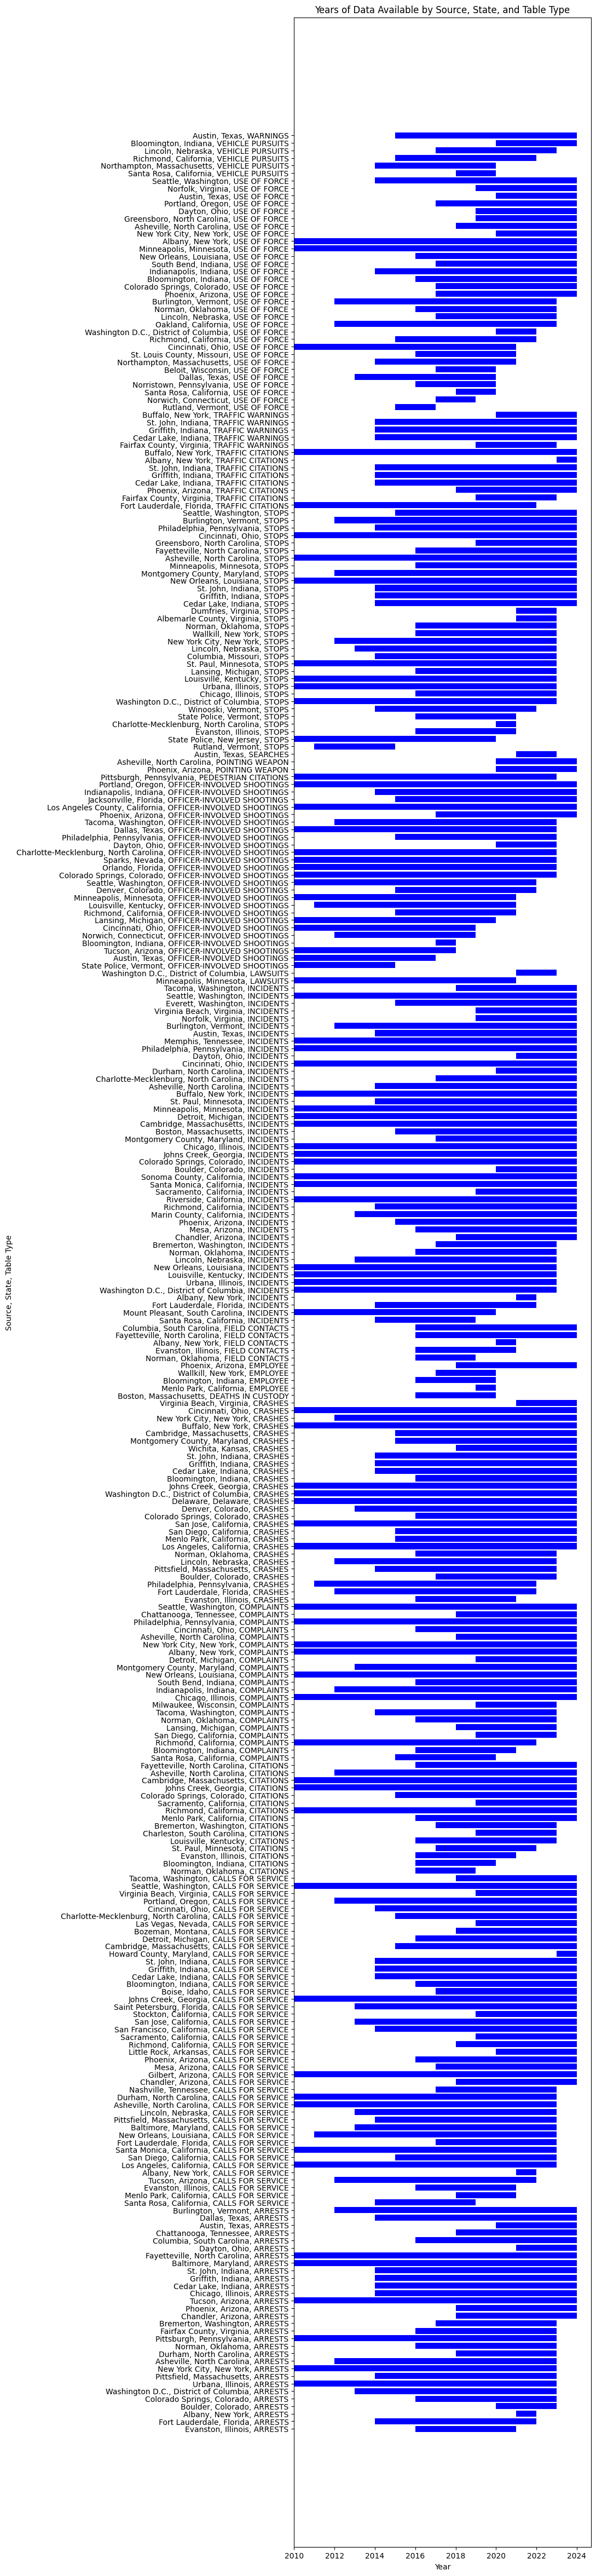

In [15]:
plot_df= df.copy()

# If the MinYear is the same as the MaxYear, then we will add a year to the MaxYear
plot_df['MaxYear'] = plot_df.apply(lambda row: row['MaxYear'] + 1 if row['MinYear'] == row['MaxYear'] else row['MaxYear'], axis=1)

# Increase min year to shrink x-limits
min_year = 2010
plot_df['MinYear'] = plot_df['MinYear'].apply(lambda x: min_year if x<min_year else x)

plot_df = plot_df.sort_values(by=['TableType','MaxYear'])

# Plot the data to see the years of data available for each unique combination of 'SourceName', 'State', 'TableType'
plt.figure(figsize=(7, 60))
ax = plt.barh(plot_df['Label'], plot_df['MaxYear'] - plot_df['MinYear'], left=plot_df['MinYear'], color='blue')
plt.xlabel('Year')
plt.ylabel('Source, State, Table Type')
plt.title('Years of Data Available by Source, State, and Table Type')
plt.show()

Table type counts (tabletype_counts >= 10) length is 9. The total number of table types is 20


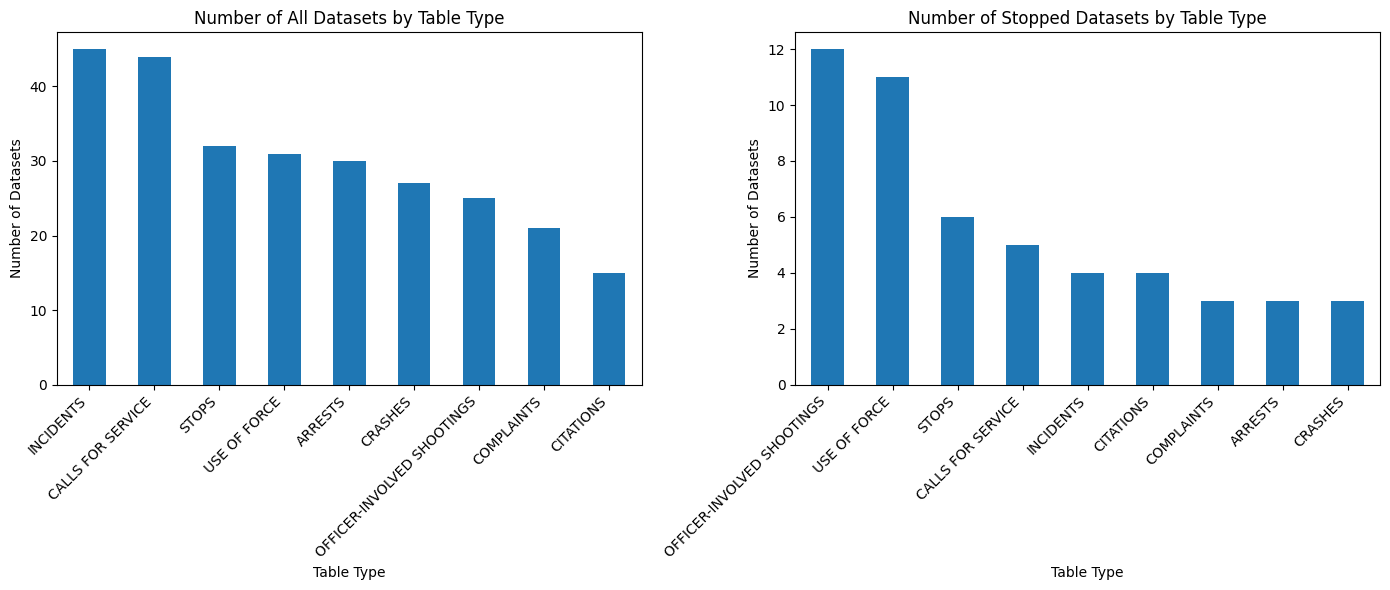

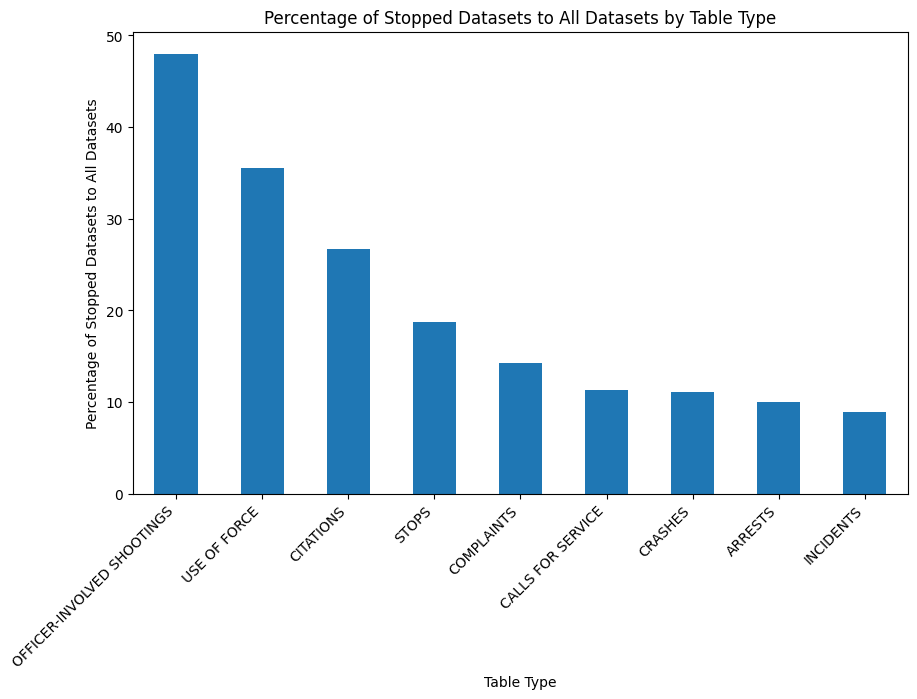

In [16]:
#Find the datasets where the data is most likely to be stopped within the year


tabletype_analysis_df = df.copy()
tabletype_counts = tabletype_analysis_df['TableType'].value_counts()

# show only statistically significant table types
total_tabletype_counts = len(tabletype_counts)
tabletype_counts = tabletype_counts[tabletype_counts >= minimum_tabletype_counts_to_show]
print(f"Table type counts (tabletype_counts >= {minimum_tabletype_counts_to_show}) length is {len(tabletype_counts)}. The total number of table types is {total_tabletype_counts}")

# filter out the table types that are not in the tabletype_counts
tabletype_analysis_df = tabletype_analysis_df[tabletype_analysis_df['TableType'].isin(tabletype_counts.index)]

stopped_datasets = tabletype_analysis_df[tabletype_analysis_df['MaxYear'] < (analysis_year_max-1)]
stopped_tabletype_counts = stopped_datasets['TableType'].value_counts()


# compute a bar graph histogram of the number of datasets that are stopped by TableType
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

tabletype_counts.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Table Type')
axes[0].set_ylabel('Number of Datasets')
axes[0].set_title('Number of All Datasets by Table Type')
axes[0].set_xticklabels(tabletype_counts.index, rotation=45, ha='right')

stopped_tabletype_counts.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Table Type')
axes[1].set_ylabel('Number of Datasets')
axes[1].set_title('Number of Stopped Datasets by Table Type')
axes[1].set_xticklabels(stopped_tabletype_counts.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Find which type has the highest ratio of stopped datasets
percentage_of_stopped_datasets = 100*(stopped_tabletype_counts / tabletype_counts)
percentage_of_stopped_datasets = percentage_of_stopped_datasets.fillna(0)

# Create a bar plot of the ratio and sort the values from high to low
percentage_of_stopped_datasets = percentage_of_stopped_datasets.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ax = percentage_of_stopped_datasets.plot(kind='bar')
ax.set_xticklabels(percentage_of_stopped_datasets.index, rotation=45, ha='right')
plt.xlabel('Table Type')
plt.ylabel('Percentage of Stopped Datasets to All Datasets')
plt.title('Percentage of Stopped Datasets to All Datasets by Table Type')
plt.show()